# Hyperparameters and Parameters
> In this introductory chapter you will learn the difference between hyperparameters and parameters. You will practice extracting and analyzing parameters, setting hyperparameter values for several popular machine learning algorithms. Along the way you will learn some best practice tips & tricks for choosing which hyperparameters to tune and what values to set & build learning curves to analyze your hyperparameter choices. This is the Summary of lecture "Hyperparameter Tuning in Python", via datacamp.

- toc: true
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Datacamp, Machine_Learning]
- image: images/accuracy_learning_curve.png

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Introduction
- Parameters
    - Components of the model learned during the modeling process
    - Do not set these manually


### Extracting a Logistic Regression parameter
You are now going to practice extracting an important parameter of the logistic regression model. The logistic regression has a few other parameters you will not explore here but you can review them in the [scikit-learn.org](https://scikit-learn.org/) documentation for the `LogisticRegression()` module under 'Attributes'.

This parameter is important for understanding the direction and magnitude of the effect the variables have on the target.

In this exercise we will extract the coefficient parameter (found in the `coef_` attribute), zip it up with the original column names, and see which variables had the largest positive effect on the target variable.

In [10]:
credit_card = pd.read_csv('credit-card-full.csv')
# To change categorical variable with dummy variables
credit_card = pd.get_dummies(credit_card, columns=['SEX', 'EDUCATION', 'MARRIAGE'], drop_first=True)
credit_card.head()

,ID,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,1,20000,24,2,2,-1,-1,-2,-2,3913,...,True,False,True,False,False,False,False,True,False,False
1,2,120000,26,-1,2,0,0,0,2,2682,...,True,False,True,False,False,False,False,False,True,False
2,3,90000,34,0,0,0,0,0,0,29239,...,True,False,True,False,False,False,False,False,True,False
3,4,50000,37,0,0,0,0,0,0,46990,...,True,False,True,False,False,False,False,True,False,False
4,5,50000,57,-1,0,-1,0,0,0,8617,...,False,False,True,False,False,False,False,True,False,False


In [11]:
from sklearn.model_selection import train_test_split

X = credit_card.drop(['ID', 'default payment next month'], axis=1)
y = credit_card['default payment next month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [12]:
from sklearn.linear_model import LogisticRegression

log_reg_clf = LogisticRegression(max_iter=1000)
log_reg_clf.fit(X_train, y_train)

# Create a list of original variable names from the training DataFrame
original_variables = X_train.columns

# Extract the coefficients of the logistic regression estimator
model_coefficients = log_reg_clf.coef_[0]

# Create a dataframe of the variables and coefficients & print it out
coefficient_df = pd.DataFrame({'Variable': original_variables,
                               'Coefficient': model_coefficients})
print(coefficient_df)

# Print out the top 3 positive variables
top_three_df = coefficient_df.sort_values(by='Coefficient', axis=0, ascending=False)[0:3]
print(top_three_df)

       Variable   Coefficient
0     LIMIT_BAL -6.484896e-07
1           AGE -1.917569e-02
2         PAY_0  2.640468e-01
3         PAY_2  1.702413e-01
4         PAY_3  1.340109e-01
5         PAY_4  1.155197e-01
6         PAY_5  1.036013e-01
7         PAY_6  9.202637e-02
8     BILL_AMT1 -6.307441e-06
9     BILL_AMT2  4.109373e-06
10    BILL_AMT3  1.397338e-06
11    BILL_AMT4 -2.756646e-06
12    BILL_AMT5 -2.567128e-08
13    BILL_AMT6  8.488914e-07
14     PAY_AMT1 -1.774069e-05
15     PAY_AMT2 -1.310900e-05
16     PAY_AMT3 -2.572483e-06
17     PAY_AMT4 -6.045999e-06
18     PAY_AMT5 -4.733806e-06
19     PAY_AMT6 -3.596428e-06
20        SEX_2 -4.281001e-02
21  EDUCATION_1 -1.238013e-02
22  EDUCATION_2 -1.929566e-02
23  EDUCATION_3  3.257405e-03
24  EDUCATION_4 -1.093358e-03
25  EDUCATION_5 -3.951482e-03
26  EDUCATION_6  2.467952e-06
27   MARRIAGE_1  2.588129e-02
28   MARRIAGE_2 -5.998234e-02
29   MARRIAGE_3  1.354026e-03
  Variable  Coefficient
2    PAY_0     0.264047
3    PAY_2     0.17024

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Extracting a Random Forest parameter
You will now translate the work previously undertaken on the logistic regression model to a random forest model. A parameter of this model is, for a given tree, how it decided to split at each level.

This analysis is not as useful as the coefficients of logistic regression as you will be unlikely to ever explore every split and every tree in a random forest model. However, it is a very useful exercise to peak under the hood at what the model is doing.

In this exercise we will extract a single tree from our random forest model, visualize it and programmatically extract one of the splits.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import os
import pydot

rf_clf = RandomForestClassifier(max_depth=4, criterion='gini', n_estimators=10);
rf_clf.fit(X_train, y_train)

# Extract the 7th (index 6) tree from the random forest
chosen_tree = rf_clf.estimators_[6]

# Convert tree to dot object
export_graphviz(chosen_tree,
                out_file='tree6.dot',
                feature_names=X_train.columns,
                filled=True,
                rounded=True)
(graph, ) = pydot.graph_from_dot_file('tree6.dot')

# Convert dot to png
graph.write_png('tree_viz_image.png')

# Visualize the graph using the provided image
tree_viz_image = plt.imread('tree_viz_image.png')
plt.figure(figsize = (16,10))
plt.imshow(tree_viz_image, aspect='auto');
plt.axis('off')

# Extract the parameters and level of the top (index 0) node
split_column = chosen_tree.tree_.feature[0]
split_column_name = X_train.columns[split_column]
split_value = chosen_tree.tree_.threshold[0]

# Print out the feature and level
print('This node split on feature {}, at a value of {}'.format(split_column_name, split_value))

FileNotFoundError: [Errno 2] "dot" not found in path.

## Introducing Hyperparameters
- Hyperparameters
    - Something you set before the modelling process (need to tune)
    - The algorithm does not learn these

### Exploring Random Forest Hyperparameters
Understanding what hyperparameters are available and the impact of different hyperparameters is a core skill for any data scientist. As models become more complex, there are many different settings you can set, but only some will have a large impact on your model.

You will now assess an existing random forest model (it has some bad choices for hyperparameters!) and then make better choices for a new random forest model and assess its performance.

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

rf_clf_old = RandomForestClassifier(min_samples_leaf=1, min_samples_split=2,
                                    n_estimators=5, oob_score=False, random_state=42)

rf_clf_old.fit(X_train, y_train)
rf_old_predictions = rf_clf_old.predict(X_test)

# Print out the old estimator, notice which hyperparameter is badly set
print(rf_clf_old)

# Get confusion matrix & accuracy for the old rf_model
print('Confusion Matrix: \n\n {} \n Accuracy Score: \n\n {}'.format(
    confusion_matrix(y_test, rf_old_predictions),
    accuracy_score(y_test, rf_old_predictions)
))

RandomForestClassifier(n_estimators=5, random_state=42)
Confusion Matrix: 

 [[6336  667]
 [1249  748]] 
 Accuracy Score: 

 0.7871111111111111


In [ ]:
# Create a new random forest classifier with better hyperparameters
rf_clf_new = RandomForestClassifier(n_estimators=500)

# Fit this to the data and obtain predictions
rf_new_predictions = rf_clf_new.fit(X_train, y_train).predict(X_test)

# Assess the new model (using new predictions!)
print('Confusion Matrix: \n\n', confusion_matrix(y_test, rf_new_predictions))
print('Accuracy Score: \n\n', accuracy_score(y_test, rf_new_predictions))

Confusion Matrix: 

 [[6638  365]
 [1235  762]]
Accuracy Score: 

 0.8222222222222222


### Hyperparameters of KNN
To apply the concepts learned in the prior exercise, it is good practice to try out learnings on a new algorithm. The k-nearest-neighbors algorithm is not as popular as it used to be but can still be an excellent choice for data that has groups of data that behave similarly. Could this be the case for our credit card users?

In this case you will try out several different values for one of the core hyperparameters for the knn algorithm and compare performance.



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Build a knn estimator for each value of n_neighbors
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_10 = KNeighborsClassifier(n_neighbors=10)
knn_20 = KNeighborsClassifier(n_neighbors=20)

# Fit each to the training data & produce predictions
knn_5_predictions = knn_5.fit(X_train, y_train).predict(X_test)
knn_10_predictions = knn_10.fit(X_train, y_train).predict(X_test)
knn_20_predictions = knn_20.fit(X_train, y_train).predict(X_test)

# Get an accuracy score for each of the models
knn_5_accuracy = accuracy_score(y_test, knn_5_predictions)
knn_10_accuracy = accuracy_score(y_test, knn_10_predictions)
knn_20_accuracy = accuracy_score(y_test, knn_20_predictions)
print('The accuracy of 5, 10, 20 neighbors was {}, {}, {}'.format(knn_5_accuracy,
                                                                  knn_10_accuracy,
                                                                  knn_20_accuracy))

The accuracy of 5, 10, 20 neighbors was 0.755, 0.7764444444444445, 0.7804444444444445


## Setting & Analyzing Hyperparameter Values


### Automating Hyperparameter Choice
Finding the best hyperparameter of interest without writing hundreds of lines of code for hundreds of models is an important efficiency gain that will greatly assist your future machine learning model building.

An important hyperparameter for the GBM algorithm is the learning rate. But which learning rate is best for this problem? By writing a loop to search through a number of possibilities, collating these and viewing them you can find the best one.

Possible learning rates to try include 0.001, 0.01, 0.05, 0.1, 0.2 and 0.5

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Set the learning rates & results storage
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5]
results_list = []

# Create the for loop to evaluate model predictions for each learning rate
for learning_rate in learning_rates:
    model = GradientBoostingClassifier(learning_rate=learning_rate)
    predictions = model.fit(X_train, y_train).predict(X_test)

    # Save the learning rate and accuracy score
    results_list.append([learning_rate, accuracy_score(y_test, predictions)])

# Gather everything into a DataFrame
results_df = pd.DataFrame(results_list, columns=['learning_rate', 'accuracy'])
print(results_df)

   learning_rate  accuracy
0          0.001  0.778111
1          0.010  0.823000
2          0.050  0.826000
3          0.100  0.825556
4          0.200  0.823333
5          0.500  0.818778


### Building Learning Curves
If we want to test many different values for a single hyperparameter it can be difficult to easily view that in the form of a DataFrame. Previously you learned about a nice trick to analyze this. A graph called a 'learning curve' can nicely demonstrate the effect of increasing or decreasing a particular hyperparameter on the final result.

Instead of testing only a few values for the learning rate, you will test many to easily see the effect of this hyperparameter across a large range of values. A useful function from NumPy is `np.linspace(start, end, num)` which allows you to create a number of values (`num`) evenly spread within an interval (`start`, `end`) that you specify.

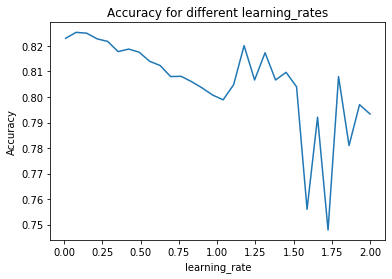

In [ ]:
# Set the learning rates & accuracies list
learn_rates = np.linspace(0.01, 2, num=30)
accuracies = []

# Create the for loop
for learn_rate in learn_rates:
    # Create the model, predictions & save the accuracies as before
    model = GradientBoostingClassifier(learning_rate=learn_rate)
    predictions = model.fit(X_train, y_train).predict(X_test)
    accuracies.append(accuracy_score(y_test, predictions))

# Plot results
plt.plot(learn_rates, accuracies);
plt.gca().set(xlabel='learning_rate', ylabel='Accuracy', title='Accuracy for different learning_rates');

You can see that for low values, you get a pretty good accuracy. However once the learning rate pushes much above 1.5, the accuracy starts to drop.